In [1]:
import random
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deap import base
from deap import creator
from deap import tools
from deap import gp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
full_data = [train_data, test_data]

map_embarked = dict(zip(train_data.Embarked.fillna(''), 
                        train_data.Embarked.fillna('').astype('category').cat.codes))

for dataset in full_data:
    # Create boolean 'IsAlone' to represent 'Sibsp' and 'Parch'
    dataset['IsAlone'] = 0
    dataset.loc[dataset['SibSp'] + dataset['Parch'] == 0, 'IsAlone'] = 1
    
    # Drop irrelevant/cumbersome columns and make 'PassengerId' the index
    dataset.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], inplace=True)
    dataset.set_index(keys=['PassengerId'], drop=True, inplace=True)

    # Create map and fill NaN values
    dataset_nan_map = {
        'Age': dataset['Age'].mean(),
        'Fare': dataset['Fare'].mean(),
    }
    dataset.fillna(value=dataset_nan_map, inplace=True)
    
    # map mixed types to numbers and fill nan values
    columns_map = {
        'Sex': {'male': 0, 'female': 1},
    }
    dataset.replace(columns_map, inplace=True)
    
    dataset['Embarked'] = dataset.Embarked.fillna('').map(map_embarked)
    
    # Change to ordinal values based on bands created above
    dataset['Age'] = dataset["Age"].apply(lambda x: 0 if x <= 16 
                                          else 1 if x > 16 and x <= 32
                                          else 2 if x > 32 and x <= 48
                                          else 3 if x > 48 and x <= 64
                                          else 4)
    dataset['Fare'] = dataset["Fare"].apply(lambda x: 0 if x <= 7.91 
                                            else 1 if x > 7.91 and x <= 14.454
                                            else 2 if x > 14.454 and x <= 31
                                            else 3)
    
# Split data
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=10)

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

random.seed(25)

pset = gp.PrimitiveSet("MAIN", arity=6)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addPrimitive(np.tan, arity=1)
pset.renameArguments(ARG0='x')

toolbox = base.Toolbox()
#2->5
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=4, max_=8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [5]:
def evalFPRFNR(individual, X_train, y_train, pset):
    func = gp.compile(expr=individual, pset=pset)
    pred = np.array([func(row['Pclass'], row['Sex'], row['Age'], row['Fare'], row['Embarked'],
             row['IsAlone']) for index, row in X_train.iterrows()])
    
    pred = MinMaxScaler().fit_transform((pred[:, np.newaxis]))
    
    tn, fp, fn, tp = confusion_matrix(y_train.values, pred.round()).ravel()
    fpr = fp/(fp+tp) if (fp+tp) != 0 else 0
    fnr = fn/(fn+tn) if (fn+tn) != 0 else 0
    
    return (fpr, fnr)


toolbox.register("evaluate", evalFPRFNR, X_train=X_train, y_train=y_train, pset=pset)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
#full->grow
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7))

In [6]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

In [7]:
pop = toolbox.population(n=500)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

Next, we will sort our population by pareto dominance in comparison to the separate individual we defined.

In [8]:
dominated = [ind for ind in pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in pop if not ind in dominated and not ind in dominators]

Next, we will plot our objective space using our sorted population.

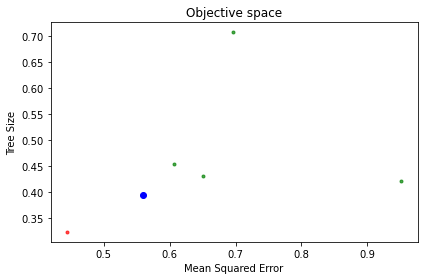

In [9]:
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('Mean Squared Error');plt.ylabel('Tree Size');
plt.title('Objective space');
plt.tight_layout()
plt.show()

The blue point is the given individual we set aside and compared all the other individuals to. The black points are uncomparable, the green points are dominated by the given individual, and the red points dominate the given individual.

We can see in this visualization how the individuals dominating our pareto front are closer to the bottom right because they have the lowest MSE and tree size. Our goal is to minimize both objectives and have an individual as close to the bottom right as possible.

A more in-depth look at DEAP, pareto fronts, and pareto dominance can be found here: https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.06%20-%20Evolutionary%20Multi-Objective%20Optimization.ipynb

Next, we will define and run the main evolutionary algorithm.

In [10]:
NGEN = 50
NXTGEN = 50
NCHILD = 100
CXPB = 0.5
MUTPB = 0.1

pop = toolbox.population(n=NXTGEN)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

logbook = tools.Logbook()
logbook.header = ['gen'] + (stats.fields)

invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
    
record = stats.compile(pop) 
logbook.record(gen=0, **record)
print(logbook.stream)

for gen in range(1, NGEN + 1):
        # Vary the population
        offspring = []
        for x in range(NCHILD):
            choice = random.random()
            if choice < CXPB:            # Apply crossover
                ind1, ind2 = map(toolbox.clone, random.sample(pop, 2))
                ind1, ind2 = toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                offspring.append(ind1)
            elif choice < CXPB + MUTPB:  # Apply mutation
                ind = toolbox.clone(random.choice(pop))
                ind, = toolbox.mutate(ind)
                del ind.fitness.values
                offspring.append(ind)
            else:                           # Apply reproduction
                offspring.append(random.choice(pop))

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if hof is not None:
            hof.update(offspring)

        # Select the next generation population
        pop[:] = toolbox.select(pop + offspring, NXTGEN)

        # Update the statistics with the new population
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(logbook.stream)

gen	avg                    	std                    	min                    	max    
0  	[0.57219913 0.47201406]	[0.15061867 0.18178424]	[0.06666667 0.14457831]	[1. 1.]
1  	[0.45621276 0.32911418]	[0.15871045 0.07583605]	[0.04 0.  ]            	[0.60060514 0.39641109]
2  	[0.37342644 0.28281951]	[0.187657   0.10248738]	[0. 0.]                	[0.6006006  0.39820359]
3  	[0.34982939 0.22335404]	[0.24307843 0.12459066]	[0. 0.]                	[0.6006006  0.39820359]
4  	[0.48430084 0.16459708]	[0.18758644 0.0759304 ]	[0. 0.]                	[0.6006006 0.3963964]  
5  	[0.48409719 0.15405198]	[0.18534414 0.06086067]	[0. 0.]                	[0.59939759 0.36692913]
6  	[0.42096371 0.16810609]	[0.2239317  0.08226164]	[0. 0.]                	[0.59939759 0.36692913]
7  	[0.2601479  0.21720718]	[0.22049527 0.09040951]	[0. 0.]                	[0.59939759 0.36692913]
8  	[0.1991007  0.23737789]	[0.19278236 0.0884834 ]	[0. 0.]                	[0.59264931 0.36692913]
9  	[0.35513054 0.17819147]	[0.1

Now, we will plot the results of our run and display the best individual.

Best individual is: sin(sin(multiply(multiply(ARG1, multiply(ARG1, x)), tan(add(ARG5, subtract(ARG4, ARG5))))))
with fitness: (0.0, 0.3669291338582677)


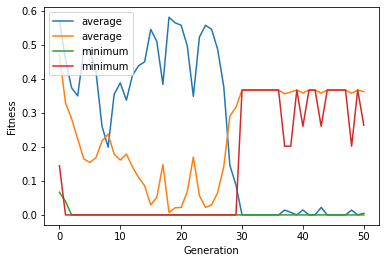

In [11]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

In the graph above, the orange and red plots represent tree size and the blue and green plots represent MSE.

This time we made use of DEAP's efficient implementations of pareto dominance and evolutionary algorithms. We used DEAP's Mu plus Lambda evolutionary algorithm. This adds two new parameters than the evolutionary loop we are used to, mu and lambda. Mu is the number of individuals to select for the next generation. Lambda is the number of children to produce at each generation.

In the plot above, we can see two trends. The size of our primitive trees raises over time, and our mean squared error quickly drops to between 0 and 1 within the first few generations.

However, that plot does not accurately represent how well our population is doing on both objectives. We can use a visualization of our objective space to show our pareto front and accurately represent how well our population is doing on both objectives.

Next, we will visualize our objective space and pareto front.

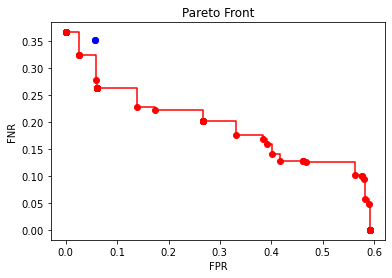

Area Under Curve: 0.1184491251135165


In [12]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

In [13]:
pred_df = pd.DataFrame(index=test_data.index)

for n, ind in enumerate(hof):
    func = gp.compile(expr=ind, pset=pset)
    pred = np.array([func(row['Pclass'], row['Sex'], row['Age'], row['Fare'], row['Embarked'],
             row['IsAlone']) for index, row in test_data.iterrows()])

    pred = MinMaxScaler().fit_transform((pred[:, np.newaxis]))
    pred = pred.flatten()
    pred_df["Survived %i" % n] = pred.round()

#pred_df.to_csv('predictions.csv', header=True, sep=',')